In [26]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from numpy.linalg import svd
from sklearn import datasets
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import pandas as pd


# Problem 1

In this problem we will look at image compression using SVD, following the lines of the well-known "Eigenfaces" experiment. The basic concept is to represent an image (in grayscale) of size $m \times n$ as an $m \times n$ real matrix $M$. SVD is then applied to this matrix to obtain $U$, $S$, and $V$ such that $M = U S V^T$. Here $U$ and $V$ are the matrices whose columns are the left and right singular vectors respectively, and $S$ is a diagonal $m \times n$ matrix consisting of the singular values of $M$. The number of non-zero singular values is the rank of $M$. By using just the largest $k$ singular values (and corresponding left and right singular vectors), one obtains the best rank-$k$ approximation to $M$.

The following code returns the dataset of 400 images.

In [27]:
data = datasets.fetch_olivetti_faces()
images = data.images

(a) Given an $m \times n$ image $M$ and its rank-$k$ approximation $A$, we can measure the reconstruction error using mean $\ell_1$ error: $$ \text{error}_{\ell_1}(M, A) = \frac{1}{mn}\| M - A \|_1 = \frac{1}{mn}\sum_{i=1}^{m}\sum_{j=1}^{n}| M_{i,j} - A_{i,j} |. $$ For $k = 1, \dots, 30$, take the average rank-$k$ reconstruction error over all images in the dataset, and plot a curve of average reconstruction error as a function of $k$.

In [28]:
# Returns the best rank-k approximation to M
def svd_reconstruct(M, k):
    # Advice: pass in full_matrices=False to svd to avoid dimensionality issues
    
    # Perform SVD
    U, S, Vt = svd(M, full_matrices=False)
    # Keep only the top k singular values
    U_k = U[:, :k]
    S_k = np.diag(S[:k])
    Vt_k = Vt[:k, :]
    # Reconstruct the matrix
    M_k = np.dot(U_k, np.dot(S_k, Vt_k))
    return M_k

In [29]:
num_images = images.shape[0]
m, n = images.shape[1], images.shape[2]
errors = []

# Calculate the average reconstruction error for k = 1 to 30
for k in range(1, 31):
    total_error = 0
    for img in images:
        M = img
        A = svd_reconstruct(M, k)
        total_error += np.mean(np.abs(M - A))
    avg_error = total_error / num_images
    errors.append(avg_error)

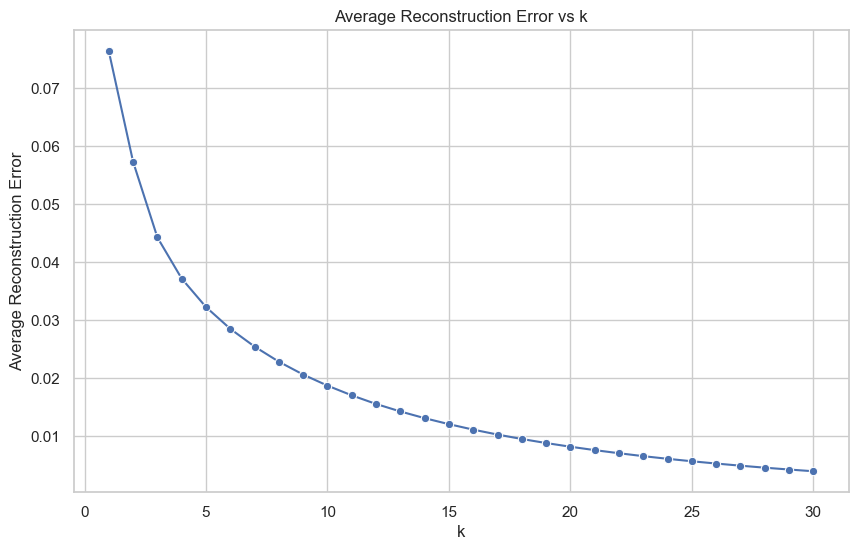

In [30]:
# Plot the average reconstruction error 
sns.set(style="whitegrid")
plt.figure(figsize=(10, 6))
sns.lineplot(x=range(1, 31), y=errors, marker='o')
plt.xlabel('k')
plt.ylabel('Average Reconstruction Error')
plt.title('Average Reconstruction Error vs k')
plt.show()

(b) Pick any image in the dataset, and display the following side-by-side as images: the original, and the best rank-$k$ approximations for $k = 10, 20, 30, 40$. You will find the `imshow` method in matplotlib useful for this; pass in `cmap='gray'` to render in grayscale. Feel free to play around further.

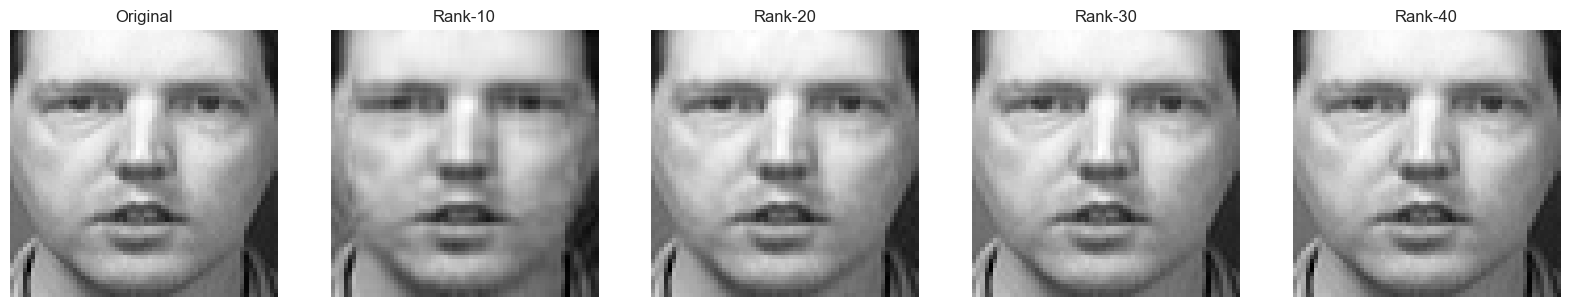

In [31]:
# Pick random image from the dataset
random_image = images[np.random.randint(0, images.shape[0]-1)]

# List of k values
k_values = [10, 20, 30, 40]

# Show original image
plt.figure(figsize=(20, 10))
plt.subplot(1, len(k_values) + 1, 1)
plt.imshow(random_image, cmap='gray')
plt.title('Original')
plt.axis('off')

# Plot the image per k result
for i, k in enumerate(k_values):
    approx_image = svd_reconstruct(random_image, k)
    plt.subplot(1, len(k_values) + 1, i + 2)
    plt.imshow(approx_image, cmap='gray')
    plt.title(f'Rank-{k}')
    plt.axis('off')

plt.show()

# Problem 2

In this problem we visualize the Wisconsin breast cancer dataset in two dimensions using PCA. First, rescale the data so that every feature has mean 0 and standard deviation 1 across the various points in the dataset. You may find `sklearn.preprocessing.StandardScaler` useful for this. Next, compute the top two principal components of the dataset using PCA, and for every data point, compute its coordinates (i.e. projections) along these two principal components. You should do this in two ways:
1. By using SVD directly. Do not use any PCA built-ins.
2. By using `sklearn.decomposition.PCA`.

The two approaches should give exactly the same result, and this also acts as a check. (But note that the signs of the singular vectors may be flipped in the two approaches since singular vectors are only determined uniquely up to sign. If this happens, flip signs to make everything identical again.)

Your final goal is to make a scatterplot of the dataset in 2 dimensions, where the x-axis is the first principal component and the y-axis is the second. Color the points by their diagnosis (malignant or benign). Do this for both approaches. Your plots should be identical. Does the data look roughly separable already in 2 dimensions?

In [32]:
cancer = datasets.load_breast_cancer()

In [33]:
X = cancer.data
y = cancer.target

# Standardize the data
scaler = StandardScaler()
X_transform = scaler.fit_transform(X)

In [34]:
# Perform PCA using SVD without built-in
U, S, Vt = np.linalg.svd(X_transform, full_matrices=False)
# The top two principal components
PCs_svd = Vt[:2].T
# Project data using PCs
X_svd_pca = np.dot(X_transform, PCs_svd)

In [35]:
# Perform PCA with built-in
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_transform)

In [36]:
# Change sign if necessary
if not np.array_equal(np.round(X_svd_pca, 5).flatten(), np.round(X_pca, 5).flatten()):
    if np.array_equal(np.round(X_svd_pca, 5).flatten(), np.round(-X_pca, 5).flatten()):
        X_svd_pca = -X_svd_pca

In [37]:
np.array_equal(np.round(X_svd_pca, 5).flatten(), np.round(X_pca, 5).flatten())

True

In [38]:
# Chnage labels to 'malignant' / 'benign'
target_names = np.array(['malignant', 'benign'])
y_mapped = target_names[y]

In [39]:
# Convert data to df
df_svd = pd.DataFrame(X_svd_pca, columns=['PC1', 'PC2'])
df_svd['Diagnosis'] = y_mapped

df_pca = pd.DataFrame(X_pca, columns=['PC1', 'PC2'])
df_pca['Diagnosis'] = y_mapped

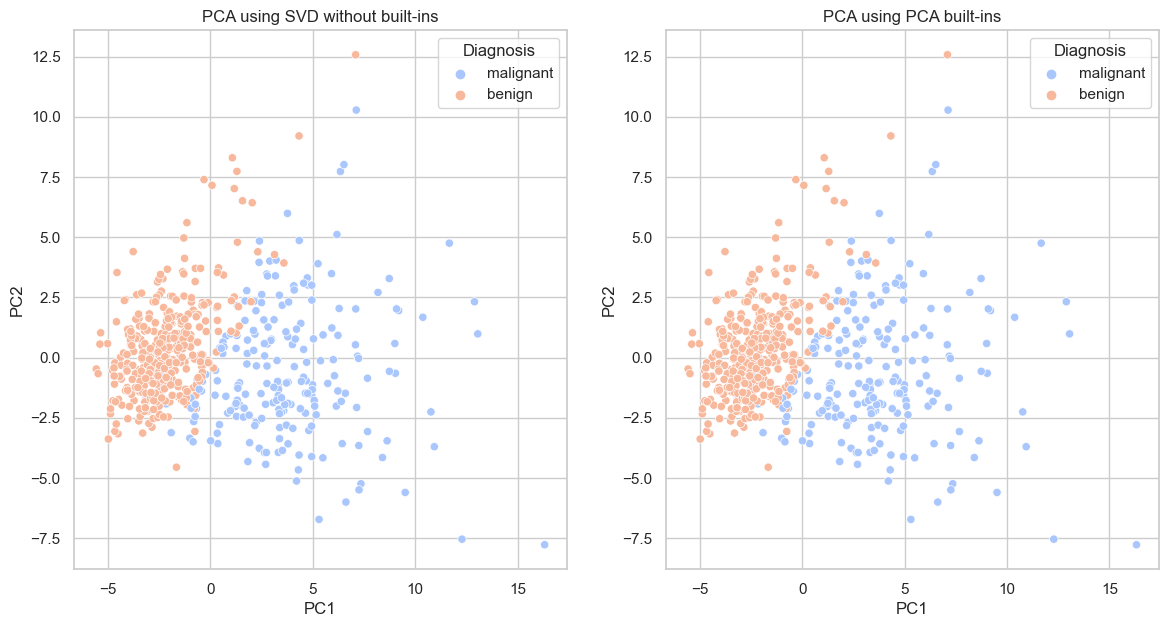

In [40]:
sns.set(style="whitegrid")

# Plot from SVD 
plt.figure(figsize=(14, 7))
plt.subplot(1, 2, 1)
sns.scatterplot(x='PC1', y='PC2', hue='Diagnosis', palette="coolwarm", data=df_svd, legend="full")
plt.title('PCA using SVD without built-ins')
plt.xlabel('PC1')
plt.ylabel('PC2')

# Plot from PCA built-in
plt.subplot(1, 2, 2)
sns.scatterplot(x='PC1', y='PC2', hue='Diagnosis', palette="coolwarm", data=df_pca, legend="full")
plt.title('PCA using PCA built-ins')
plt.xlabel('PC1')
plt.ylabel('PC2')

plt.show()